In [17]:
from sklearn import datasets
import warnings
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from autocluster.autohypothesis import autohypothesis_utils

In [18]:
import time
start_time = time.time()
# Test
synthetic_df = autohypothesis_utils.create_dataset(n=10, k=500, c=3, b=4)
exp,X_train, X_dev, y_train, y_dev  = autohypothesis_utils.opti_loop(synthetic_df,500, optimize_obj="dual")
end_time = time.time()
execution_time = end_time - start_time

[I 2024-04-23 14:38:44,184] A new study created in memory with name: no-name-3630f336-0a9f-4bdc-b308-14c577bc6303
[I 2024-04-23 14:38:44,558] Trial 0 finished with values: [0.3333333333333333, 0.0] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 510, 'rf_max_depth': 25, 'rf_min_samples_split': 0.6918876075775979, 'rf_min_samples_leaf': 0.3023156376962773, 'rf_max_features': 'sqrt', 'rf_random_state': 42}. 
[I 2024-04-23 14:38:45,301] Trial 1 finished with values: [0.7533333333333333, 0.4916645656410311] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 920, 'rf_max_depth': 9, 'rf_min_samples_split': 0.5348747486410517, 'rf_min_samples_leaf': 0.18590616623530656, 'rf_max_features': 'log2', 'rf_random_state': 42}. 
[I 2024-04-23 14:38:45,463] Trial 2 finished with values: [0.7533333333333333, 0.43382842337483807] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 170, 'rf_max_depth': 22, 'rf_min_samples_split': 0.1883800229645628, 'rf_min_

In [19]:
fig = optuna.visualization.plot_pareto_front(exp, target_names=["Accuracy", "Entropie"], include_dominated_trials=False)
#fig = optuna.visualization.plot_pareto_front(motpe_experiment, target_names=["objective 1", "objective 2"])
fig.layout.title = 'Pareto-front MOTPE'
fig

In [20]:
all_objectives = np.array([trial.values for trial in exp.best_trials ])
#all_objectives = np.unique(all_objectives, axis=0)
sorted_objectives = all_objectives[np.argsort(all_objectives[:, 0])]
spread = np.mean(np.sqrt(np.sum(np.diff(sorted_objectives, axis=0)**2, axis=1)))
# Uniformité
uniformity = np.mean(np.std(np.diff(sorted_objectives, axis=0), axis=0))

# Taille du Front
front_size = len(all_objectives)
all_objectives

array([[0.77333333, 0.53408366],
       [0.78      , 0.51730296],
       [0.74      , 0.53788667],
       [0.74      , 0.53788667],
       [0.75333333, 0.53411262],
       [0.58666667, 1.        ],
       [0.58666667, 1.        ],
       [0.61333333, 0.58580296],
       [0.6       , 0.72531212],
       [0.60666667, 0.62366149],
       [0.78666667, 0.4940916 ]])

In [21]:
exp.best_trials

[FrozenTrial(number=126, state=TrialState.COMPLETE, values=[0.7733333333333333, 0.5340836631608494], datetime_start=datetime.datetime(2024, 4, 23, 14, 39, 55, 612129), datetime_complete=datetime.datetime(2024, 4, 23, 14, 39, 55, 874129), params={'classifier': 'RandomForest', 'rf_n_estimators': 260, 'rf_max_depth': 21, 'rf_min_samples_split': 0.13772471419142557, 'rf_min_samples_leaf': 0.2862457566597607, 'rf_max_features': 'log2', 'rf_random_state': 42}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'rf_n_estimators': IntDistribution(high=1000, log=False, low=10, step=10), 'rf_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'rf_min_samples_split': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'rf_min_samples_leaf': FloatDistribution(high=0.5, log=False, low=0.01, step=None), 'rf_max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'rf_random_state': Int

In [22]:
data = []
for trial in exp.best_trials:
    # Ici, on suppose que `values` contient [accuracy, entropy] dans cet ordre
    accuracy, entropy = (round(val, 3) for val in trial.values) if trial.values else (None, None)
    data.append({
        'number': trial.number,
        'accuracy': accuracy,
        'entropy': 1-entropy,
        'params': trial.params
    })

# Convertir la liste de dictionnaires en un DataFrame
df = pd.DataFrame(data)
df.to_csv("opti_duo_500_synth.csv")

In [23]:
#print(f"Spread: {spread}", f"Uniformity: {uniformity}", f"Front size: {front_size}", sep="\n")

In [24]:
params = autohypothesis_utils.get_trial_hyperparams(exp, trial_number=10) 
pipeline = autohypothesis_utils.rebuild_pipeline_with_hyperparams(params)
pipeline.fit(X_train, y_train)
acc = accuracy_score(y_dev, pipeline.predict(X_dev))
entropy = autohypothesis_utils.clusterEntropy(pipeline, X_dev, pipeline.predict(X_dev))
print(f"Accuracy: {acc:.4f} - Entropy: {1-entropy:.4f}")


Accuracy: 0.7467 - Entropy: 0.5289


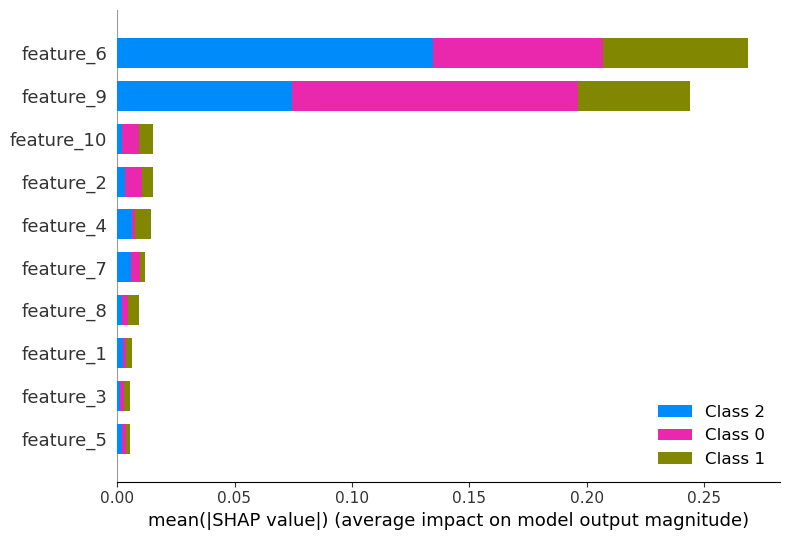

In [25]:
import shap

# Initialize your explainer
explainer = shap.Explainer(pipeline.named_steps['classifier'])

# Compute SHAP values
shap_values = explainer.shap_values(X_dev)

# Summarize the SHAP values in a plot
shap.summary_plot(shap_values, X_dev)


In [26]:
import numpy as np

unique_classes = np.unique(y_dev)
random_ids = {}

for cls in unique_classes:
    # Obtenir les indices de toutes les instances de cette classe
    class_indices = np.where(y_dev == cls)[0]
    # Sélectionner aléatoirement un indice parmi ces indices
    random_id = np.random.choice(class_indices)
    random_ids[cls] = random_id

print(random_ids)


{0: 123, 1: 111, 2: 87}


In [27]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][random_ids[0]], X_dev.iloc[random_ids[0]])


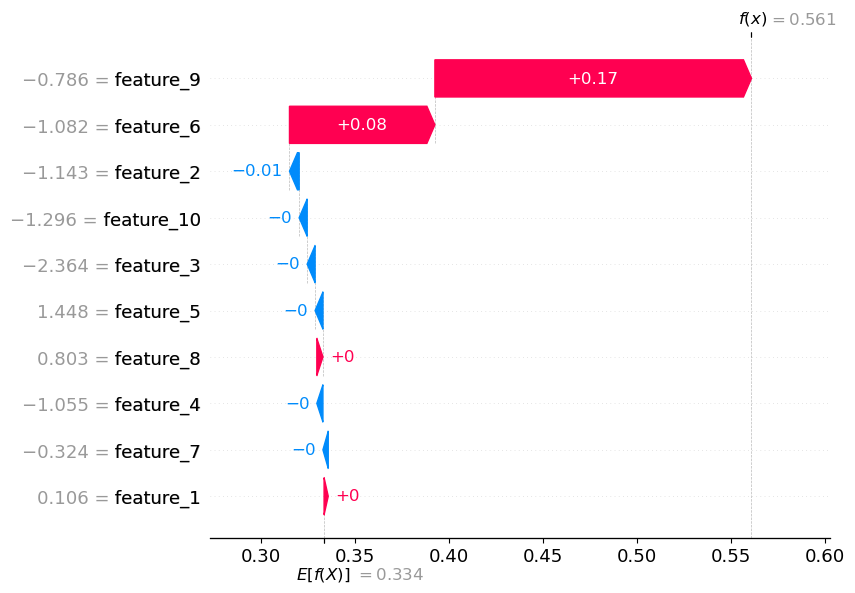

In [28]:
row = random_ids[0]
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [29]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][random_ids[1]], X_dev.iloc[random_ids[1]])

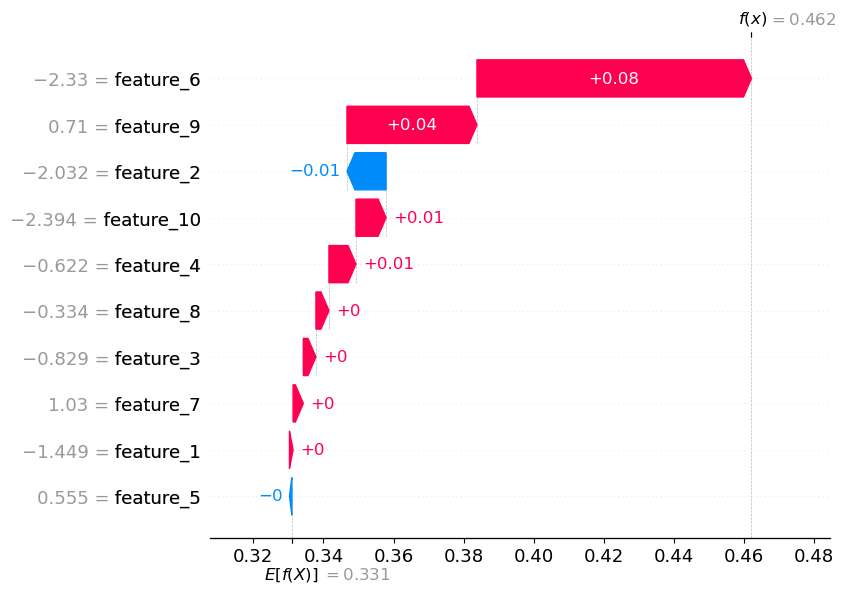

In [30]:
row = random_ids[1]
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [31]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][random_ids[2]], X_dev.iloc[random_ids[2]])

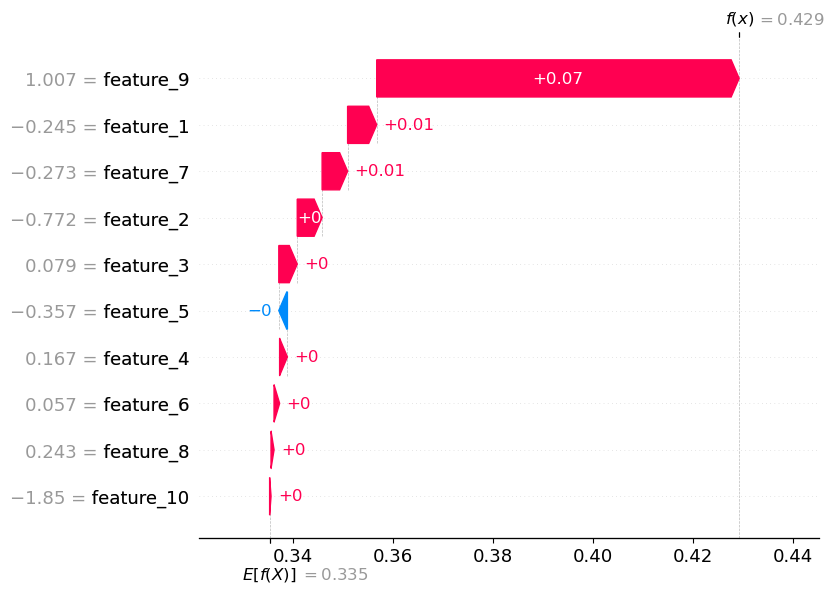

In [32]:
row = random_ids[2]
shap.waterfall_plot(shap.Explanation(values=shap_values[2][row],
                                              base_values=explainer.expected_value[2], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))